# Preamble

In [1]:
from load_functions import *
from model_functions import *
import emcee

plt.rcdefaults()
fontsize = 14
rcParams['font.family'] = 'sans-serif'
font_manager.findfont('serif', rebuild_if_missing=True)
rcParams.update({'font.size':fontsize})

In [2]:
HomeDir = '/Users/kvantilburg/Dropbox/projects/LuminousBasin/LuminousBasin/luminous-basin/'
DataDir = HomeDir+'data/likelihood_yellin_data/products_80610202001_orbit1_chu12_spatialARF/'
ResultsDir = HomeDir+'data/results/'
import sys
sys.path.insert(0, HomeDir)

# Parameters

In [4]:
m = 18.0 # axion mass
sigma_E = 0.166 # energy resolution

In [5]:
good_time_ints = [
(  3.37603080e+08,   3.37603330e+08),
(  3.37603330e+08,   3.37603380e+08),
(  3.37603380e+08,   3.37603380e+08),
(  3.37603580e+08,   3.37603581e+08),
(  3.37603630e+08,   3.37605080e+08),
(  3.37605081e+08,   3.37605230e+08)]
exposure = np.sum([interval[1]-interval[0] for interval in good_time_ints])
livetime = np.asarray([1501.16599845754, 1481.86081041239])/exposure # effective fractional livetime of A and B
duration = np.max(good_time_ints)- np.min(good_time_ints)

In [6]:
# time bins
N_bins_t = 10
bins_t = np.linspace(good_time_ints[1][0], good_time_ints[-1][1], N_bins_t+1)
# energy bins
width_E = 0.04 # energy bin width is 40 keV
bins_E = np.arange(1.6,200.01,width_E)
n_sigma_E = 3

In [7]:
list_file_events = [DataDir+'event_lists/'+file for file in listdir(DataDir+'event_lists/') if file[0:2]=='nu'] #select only files starting with 'nu'
file_box_centers = DataDir+'box_centers.txt'
list_file_arf = [DataDir+'arfs/'+file for file in listdir(DataDir+'arfs/')]

In [8]:
# fiducial solar position 
ra_sun_fid = 170.66855149 * degree
dec_sun_fid = 4.02092024 * degree
# error on solar position 
sigma_sun = 2 * arcmin
# shift in solar position over duration starting from t_min
delta_ra_sun = 0.01962028 * degree
delta_dec_sun = -0.00835105 * degree
t_min = 3.37603341e+08
sigma_sun = 2*arcmin # error on solar position

# initial solar position
ra_sun_0 = ra_sun_fid
dec_sun_0 = dec_sun_fid

# Load Data

In [9]:
df_data = load_data(m,sigma_E,good_time_ints,livetime,bins_t,bins_E,n_sigma_E,list_file_events,file_box_centers,list_file_arf)

In [10]:
df_data

,detector,idx_t,idx_E,i1,i2,t,E,ra,dec,exp,arf,Omega,counts
0,A,0,173,-6,-6,337603330.0,8.52,170.889,3.75981,39.504368,113.094009,1.0,0
1,A,0,173,-6,-5,337603330.0,8.52,170.881,3.77425,39.504368,82.943665,1.0,0
2,A,0,173,-6,-4,337603330.0,8.52,170.872,3.78868,39.504368,138.742828,1.0,0
3,A,0,173,-6,-3,337603330.0,8.52,170.864,3.80311,39.504368,138.469910,1.0,0
4,A,0,173,-6,-2,337603330.0,8.52,170.856,3.81755,39.504368,244.743439,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84495,B,9,197,6,2,337605040.0,9.48,171.009,3.97187,147.406154,135.821762,1.0,0
84496,B,9,197,6,3,337605040.0,9.48,171.001,3.98630,147.406154,110.902191,1.0,0
84497,B,9,197,6,4,337605040.0,9.48,170.992,4.00073,147.406154,79.826294,1.0,0
84498,B,9,197,6,5,337605040.0,9.48,170.984,4.01517,147.406154,77.881058,1.0,0


In [11]:
t = df_data['t'].to_numpy()
E = df_data['E'].to_numpy()
ra = df_data['ra'].to_numpy()
dec = df_data['dec'].to_numpy()
eps = df_data['exp'].to_numpy() * df_data['arf'].to_numpy() * (df_data['Omega'].to_numpy() * arcmin**2 / (degree**2)) * width_E
counts = df_data['counts'].to_numpy()

In [12]:
df_results_yellin = pd.read_csv(ResultsDir+'results_k10_fid.csv')
df_results_yellin

,m,ra_sun_0,dec_sun_0,rho_0,N_data,N_sig_lim_poisson,S_0_lim_poisson,N_sig_lim_yellin,S_0_lim_yellin
0,3.2,2.978728,0.070178,296.513448,12721,12864.742387,43.386708,6325.111361,21.331617
1,3.3,2.978728,0.070178,398.950885,13348,13495.882921,33.828432,6319.313656,15.839829
2,3.4,2.978728,0.070178,514.408935,13930,14079.962107,27.371146,6463.155766,12.564237
3,3.5,2.978728,0.070178,645.655228,14995,15151.017660,23.466112,5806.716361,8.993525
4,3.6,2.978728,0.070178,785.449821,15448,15607.089944,19.870257,5558.469388,7.076798
...,...,...,...,...,...,...,...,...,...
363,39.5,2.978728,0.070178,25392.314178,9,14.204028,0.000559,2.303297,0.000091
364,39.6,2.978728,0.070178,25307.006674,9,14.204028,0.000561,2.303297,0.000091
365,39.7,2.978728,0.070178,25218.871552,9,14.204028,0.000563,2.303297,0.000091
366,39.8,2.978728,0.070178,25089.057583,9,14.204028,0.000566,2.303297,0.000092


In [13]:
idx = np.where(np.abs(df_results_yellin['m']-m)<0.05)[0][0]
S0_guess = df_results_yellin['S_0_lim_poisson'][idx]
df_results_yellin.iloc[idx]

m                       18.000000
ra_sun_0                 2.978728
dec_sun_0                0.070178
rho_0                60568.120963
N_data                  30.000000
N_sig_lim_poisson       38.308560
S_0_lim_poisson          0.000632
N_sig_lim_yellin        13.085792
S_0_lim_yellin           0.000216
Name: 148, dtype: float64

# Raw data distribution

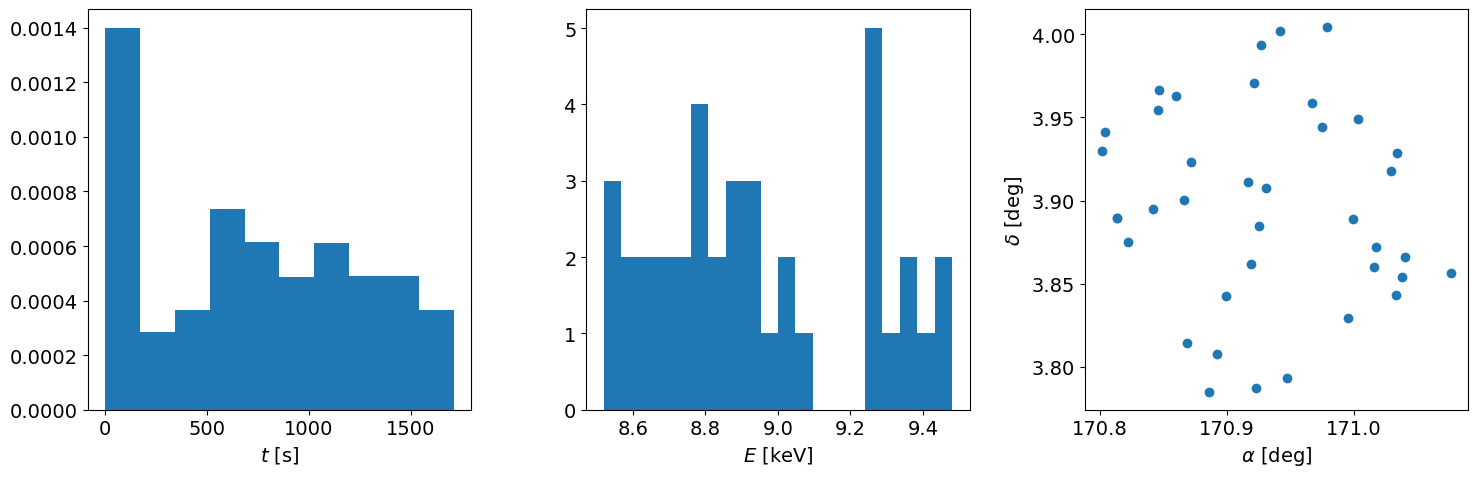

In [14]:
fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].hist(t-np.min(t),weights=counts/df_data['exp'],density=True,bins=10);
ax[0].set_xlabel(r'$t~[\mathrm{s}]$')
ax[1].hist(E,weights=counts,bins=20)
ax[1].set_xlabel(r'$E~[\mathrm{keV}]$');
ax[2].scatter(ra[counts>0],dec[counts>0])
ax[2].scatter(ra[counts>1],dec[counts>1])
ax[2].set_xlabel(r'$\alpha~[\mathrm{deg}]$');
ax[2].set_ylabel(r'$\delta~[\mathrm{deg}]$');
fig.tight_layout();

# Checks

In [15]:
np.sum(counts), df_results_yellin.iloc[idx]['N_data']

(38, 30.0)

In [16]:
S0_guess * np.mean(T_flux_template(t,ra,dec,ra_sun_0,dec_sun_0,delta_ra_sun,delta_dec_sun,t_min,duration)) * np.mean(df_data['arf']) * (2*13**2*arcmin**2 / degree**2) * exposure * 4 * sigma_E

33.94700257932755

# MCMC

## 3 dimensions (old)

In [298]:
def LL_prior_BTS(B0,T0,S0):
    LL_prior_T0 = np.piecewise(T0,[T0<=0,T0>0],[-1e1*T0,1e0*T0])
    LL_prior_B0 = np.piecewise(B0,[B0<=0,B0>0],[-1e5*B0,1e-10*B0])
    LL_prior_S0 = np.piecewise(S0,[S0<=0,S0>0],[-1e-5*S0,1e-5*S0])
    return LL_prior_T0 + LL_prior_B0 + LL_prior_S0

In [299]:
def likelihood_MCMC_3(model_inputs,m,t,E,ra,dec,eps,counts):
    B0 = model_inputs[0]
    T0 = model_inputs[1]
    S0 = model_inputs[2]
    #alpha0=170.66855149
    #delta0=4.02092024
    ra_sun_0 = ra_sun_fid
    dec_sun_0 = dec_sun_fid
    flux_bkgd = B0*np.exp(-(E-m/2)/T0)
    flux_signal = S0 * T_flux_template(t,ra,dec,ra_sun_0,dec_sun_0,delta_ra_sun,delta_dec_sun,t_min,duration) * np.exp(-(E-m/2)**2/(2*sigma_E**2)) / np.sqrt(2 * np.pi * sigma_E**2)
    mu = (flux_bkgd + flux_signal) * eps
    
    LLp = LL_prior_BTS(B0,T0,S0)
    
    if np.min(mu) < 0: 
        return -np.inf
    else:
        try:
            #LL = counts*np.log(mu)-mu-np.log(factorial_vec(counts)) 
            LL = counts*np.log(mu)-mu # not including factorial, as it does not depend on model params
            loss = 2 * (np.sum(LL) - LLp)
            return loss
        except ValueError:
            return -np.inf

In [300]:
nwalkers = 32
ndim = 3 # B0,T0,S0,alpha0,delta0
p0_B0 = np.abs(np.random.normal(10*S0_guess,10*S0_guess,nwalkers))
p0_T0 = np.abs(np.random.normal(0.2,0.05,nwalkers))
p0_S0 = np.random.normal(0.3*S0_guess,0.3*S0_guess,nwalkers)
p0 = np.transpose([p0_B0,p0_T0,p0_S0])

In [301]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, likelihood_MCMC_3, args=[m,t,E,ra,dec,eps,counts])

In [302]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

In [303]:
n_steps = 200;
sampler.run_mcmc(state, n_steps, progress=True);

100%|██████████| 200/200 [01:13<00:00,  2.72it/s]


In [304]:
samples = sampler.get_chain(flat=True)

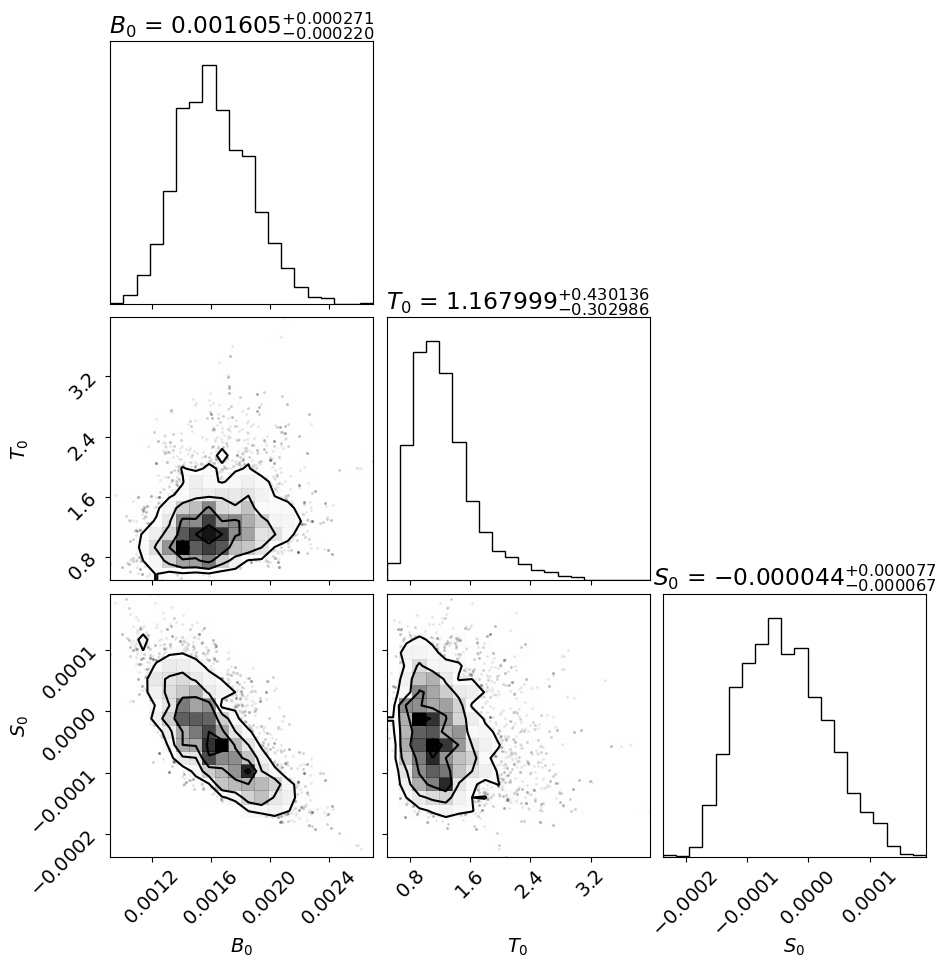

In [308]:
labels = ['$B_0$','$T_0$','$S_0$']
fig,ax=plt.subplots(3,3,figsize=(10,10))
corner.corner(samples,fig=fig,labels=labels,show_titles=True,title_fmt='.6f',use_math_text=True);

## 5 dimensions

In [453]:
def LL_prior_sun(ra_sun_0,dec_sun_0,sigma_sun=sigma_sun,ra_sun_fid=ra_sun_fid,dec_sun_fid=dec_sun_fid):
    return (np.cos(dec_sun_fid)**2 * (ra_sun_0 - ra_sun_fid)**2 + (dec_sun_0 - dec_sun_fid)**2) / (2 * sigma_sun**2)

def LL_prior_BTS(B0,T0,S0):
    LL_prior_T0 = np.piecewise(T0,[T0<=0,T0>0],[-1e1*T0,1e0*T0])
    LL_prior_B0 = np.piecewise(B0,[B0<=0,B0>0],[-1e5*B0,1e-10*B0])
    LL_prior_S0 = np.piecewise(S0,[S0<=0,S0>0],[-1e-5*S0,1e-5*S0])
    return LL_prior_T0 + LL_prior_B0 + LL_prior_S0

def LL_prior(B0,T0,S0,ra_sun_0,dec_sun_0):
    return LL_prior_sun(ra_sun_0,dec_sun_0) + LL_prior_BTS(B0,T0,S0)

In [454]:
def likelihood_MCMC_5(model_inputs,m,t,E,ra,dec,eps,counts):
    B0 = model_inputs[0]
    T0 = model_inputs[1]
    S0 = model_inputs[2]
    #alpha0=170.66855149
    #delta0=4.02092024
    ra_sun_0 = model_inputs[3]
    dec_sun_0 = model_inputs[4]
    flux_bkgd = B0*np.exp(-(E-m/2)/T0)
    flux_signal = S0 * T_flux_template(t,ra,dec,ra_sun_0,dec_sun_0,delta_ra_sun,delta_dec_sun,t_min,duration) * np.exp(-(E-m/2)**2/(2*sigma_E**2)) / np.sqrt(2 * np.pi * sigma_E**2)
    mu = (flux_bkgd + flux_signal) * eps
    
    LLp = LL_prior(B0,T0,S0,ra_sun_0,dec_sun_0)
    
    if np.min(mu) < 0: 
        return -np.inf
    else:
        try:
            #LL = counts*np.log(mu)-mu-np.log(factorial_vec(counts)) 
            LL = counts*np.log(mu)-mu # not including factorial, as it does not depend on model params
            loss = 2 * (np.sum(LL) - LLp)
            return loss
        except ValueError:
            return -np.inf

In [463]:
nwalkers = 32
ndim = 5 # B0,T0,S0,alpha0,delta0
p0_B0 = np.abs(np.random.normal(10*S0_guess,10*S0_guess,nwalkers))
p0_T0 = np.abs(np.random.normal(0.2,0.05,nwalkers))
p0_S0 = np.random.normal(0.3*S0_guess,0.3*S0_guess,nwalkers)
p0_ra_sun_0 = np.random.normal(ra_sun_fid,sigma_sun,nwalkers)
p0_dec_sun_0 = np.random.normal(dec_sun_fid,sigma_sun,nwalkers)
p0 = np.transpose([p0_B0,p0_T0,p0_S0,p0_ra_sun_0,p0_dec_sun_0])

In [464]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, likelihood_MCMC_5, args=[m,t,E,ra,dec,eps,counts])

In [465]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

In [466]:
n_steps = 3000;
sampler.run_mcmc(state, n_steps, progress=True);

 29%|██▉       | 877/3000 [04:52<11:59,  2.95it/s]/var/folders/x1/dts9vq8x5016gkhg985pdgjm0001m4/T/ipykernel_98129/3750699651.py:9: RuntimeWarning: overflow encountered in exp
  flux_bkgd = B0*np.exp(-(E-m/2)/T0)
100%|██████████| 3000/3000 [40:20<00:00,  1.24it/s]     


In [467]:
samples = sampler.get_chain(flat=True)

In [468]:
units = np.asarray([1e3,1e0,1e4,180/np.pi,180/np.pi])

In [469]:
samples_units = np.transpose(np.diag(units) @ np.transpose(samples))

Quantiles:
[(0.0015, 6.542098666010786), (0.1, 9.783165890792386), (0.5, 13.023212966243438), (0.9, 33.807057013817236), (0.9985, 37.425210716641935)]
Quantiles:
[(0.0015, 0.1534453853185963), (0.1, 0.1817799775348425), (0.5, 0.20895430469915596), (0.9, 0.3572944777860033), (0.9985, 0.41250966062384864)]
Quantiles:
[(0.0015, -29.882882452476302), (0.1, -25.525564501886084), (0.5, 57.43602923974379), (0.9, 72.70546686240192), (0.9985, 92.66789696910544)]
Quantiles:
[(0.0015, 170.54892412873505), (0.1, 170.57804819295453), (0.5, 170.60514748084455), (0.9, 170.70330470319345), (0.9985, 170.75778418721654)]
Quantiles:
[(0.0015, 3.985809550658523), (0.1, 4.035424156875759), (0.5, 4.110233720352921), (0.9, 4.147696938275002), (0.9985, 4.179859584317555)]


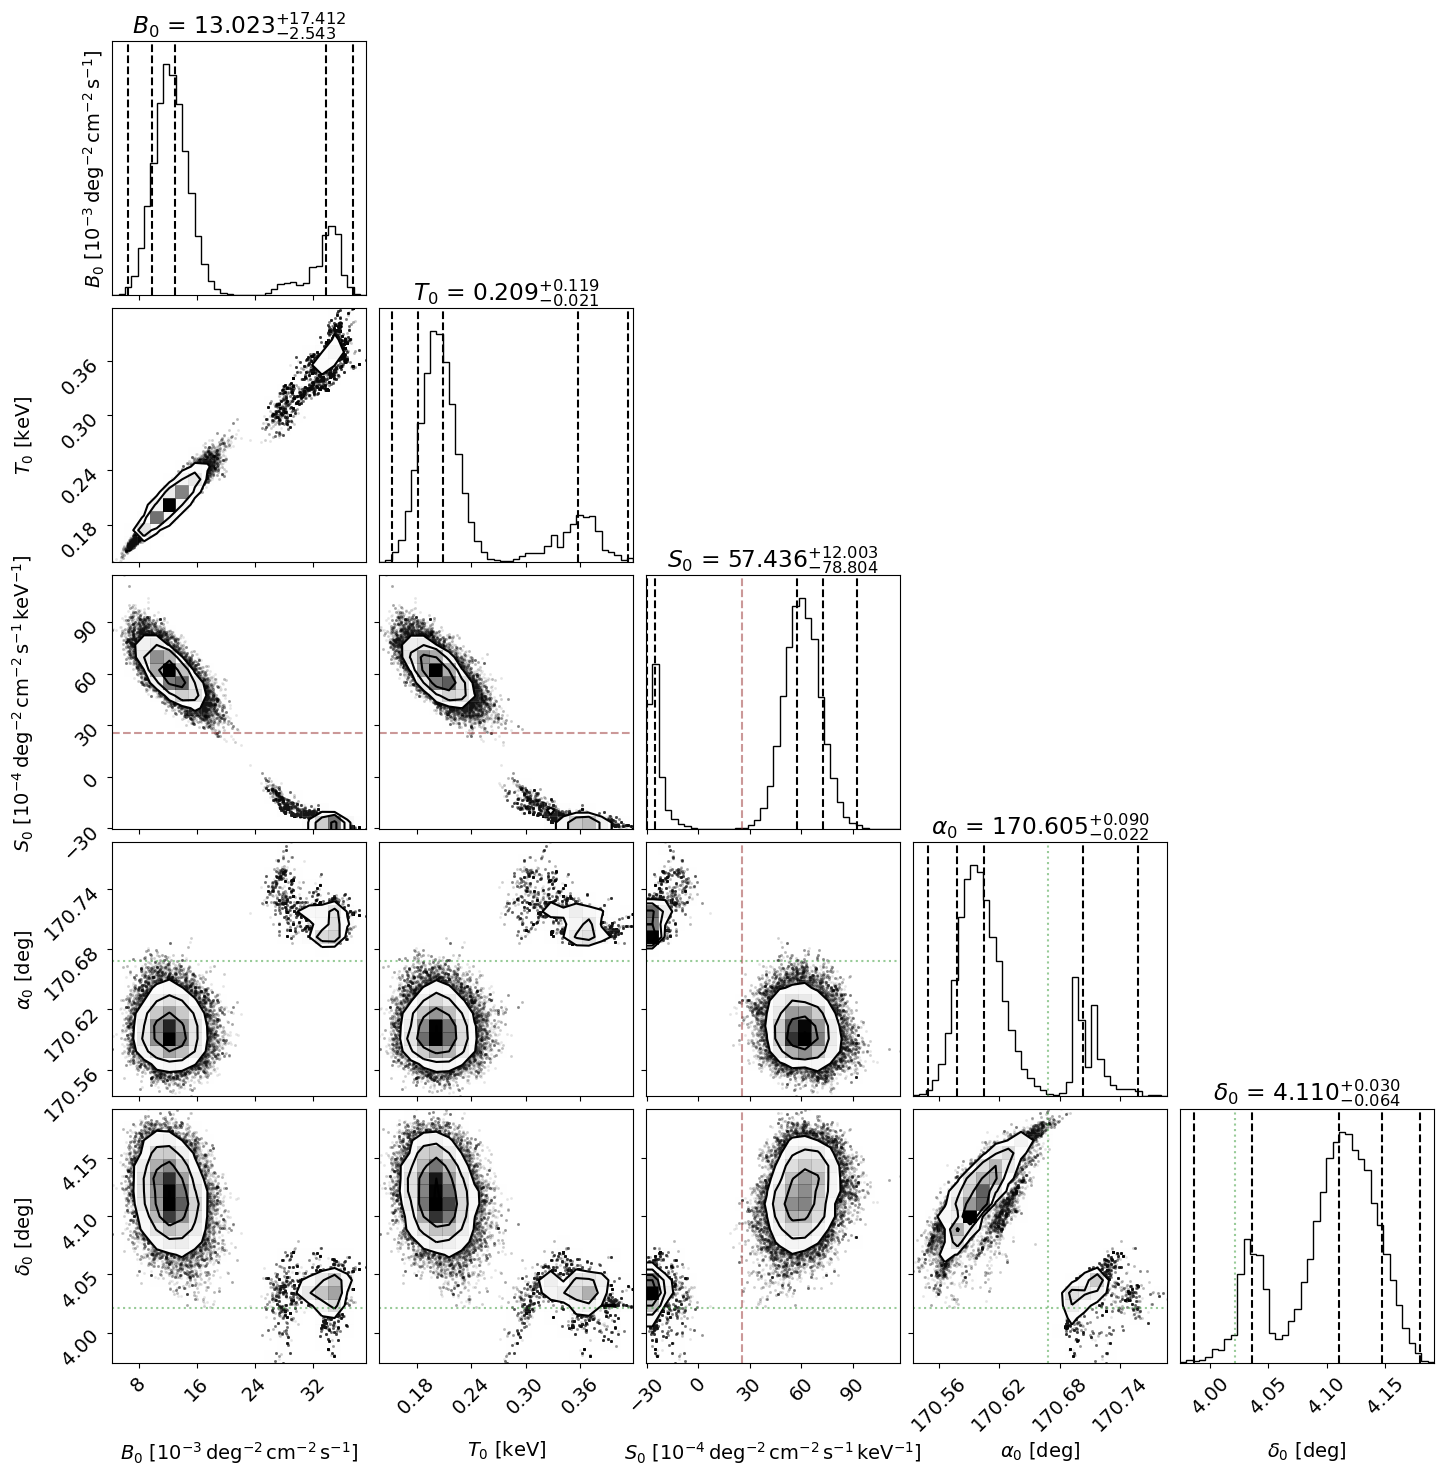

In [481]:
labels = [r'$B_0$',r'$T_0$',r'$S_0$',r'$\alpha_0$',r'$\delta_0$']
x_labels = [r'$B_0~[10^{-3}\,\mathrm{deg^{-2}\,cm^{-2}\,s^{-1}}]$',r'$T_0~[\mathrm{keV}]$',r'$S_0~[10^{-4}\,\mathrm{deg^{-2}\,cm^{-2}\,s^{-1}\,keV^{-1}}]$',r'$\alpha_0~[\mathrm{deg}]$',r'$\delta_0~[\mathrm{deg}]$']
fig,ax=plt.subplots(5,5,figsize=(15,15))
corner.corner(samples_units,quantiles=[1.5e-3,0.1,0.5,0.9,0.9985],
              fig=fig,labels=labels,show_titles=True,title_fmt='.3f',scale_hist=False,hist_bin_factor=2,top_ticks=False,verbose=True)
for i,x_label in enumerate(x_labels):
    ax[i,0].set_ylabel(x_label)
    ax[4,i].set_xlabel(x_label)
for i in range(2,5):
    ax[i,2].axvline(units[2] * df_results_yellin['S_0_lim_yellin'][idx],color=(0.6,0.2,0.2,0.5),ls='dashed')
for i in range(2):
    ax[2,i].axhline(units[2] * df_results_yellin['S_0_lim_yellin'][idx],color=(0.6,0.2,0.2,0.5),ls='dashed')
for i in range(3,5):
    ax[i,3].axvline(units[3] * ra_sun_fid,color=(0.2,0.6,0.2,0.5),ls='dotted')
for i in range(3):
    ax[3,i].axhline(units[3] * ra_sun_fid,color=(0.2,0.6,0.2,0.5),ls='dotted')
for i in range(4,5):
    ax[i,4].axvline(units[4] * dec_sun_fid,color=(0.2,0.6,0.2,0.5),ls='dotted')
for i in range(4):
    ax[4,i].axhline(units[4] * dec_sun_fid,color=(0.2,0.6,0.2,0.5),ls='dotted')

# Plot Shalma's MCMC run

In [3]:
MCMCDir = HomeDir+'~/Dropbox/project/LuminousBasin/LuminousBasin/code/Ken/MCMC_data/'

In [4]:
pd.read_csv(MCMCDir+'output_samples_51.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kvantilburg/Dropbox/projects/LuminousBasin/LuminousBasin/luminous-basin/MCMC_data/output_samples_51.csv'

# OLD BELOW HERE

# Likelihood

In [13]:
B0 = 1.0
T0 = 5.3
S0 = 10
alpha0 = 171
delta0 = 4.5

In [14]:
mu_bckg_slope = np.exp(-(E-m/2)/T0)
mu_sig_T = T_flux_template(ra,dec,t,duration,alpha0,delta0)
mu_sig_lineshape = np.exp(-(E-m/2)**2/(2*sigma_E**2)) / np.sqrt(2 * np.pi * sigma_E**2)

In [21]:
mu = B0 * mu_bckg_slope + S0 * mu_sig_T * mu_sig_lineshape * eps 

In [22]:
%timeit mu = B0 * mu_bckg_slope + S0 * mu_sig_T * mu_sig_lineshape * eps

135 µs ± 825 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
def flux_model(t,E,ra,dec,m,B0,T0,S0,alpha0,delta0,duration,sigma_E=0.166):
    flux_bckg = B0*np.exp(-(E-m/2)/T0)
    flux_signal = S0 * T_flux_template(ra,dec,t,duration,alpha0,delta0) * np.exp(-(E-m/2)**2/(2*sigma_E**2)) / np.sqrt(2 * np.pi * sigma_E**2)
    return flux_bckg + flux_signal

In [18]:
mu = flux_model(t,E,ra,dec,m,B0,T0,S0,alpha0,delta0,duration) * eps

In [20]:
len(mu)

60840

In [15]:
%timeit flux_model(t,E,ra,dec,m,B0,T0,S0,alpha0,delta0,duration) * eps

9.17 ms ± 560 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
def likelihood(mu,counts):
    return -counts*np.log(mu)+mu+np.log(factorial_vec(counts))

In [25]:
%timeit likelihood(mu,counts)

4.43 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%timeit np.sum(-counts*np.log(mu)+mu)

379 µs ± 4.39 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Tests

## Load events

In [14]:
df_events = load_events(list_file_events)
df_events

,detector,t,E,ra,dec
0,A,3.376033e+08,2.04,170.894753,3.983816
1,A,3.376033e+08,1.88,170.902966,3.914852
2,A,3.376033e+08,2.20,170.859849,3.921680
3,A,3.376033e+08,2.48,170.910495,3.991327
4,A,3.376033e+08,2.88,170.956349,3.940799
...,...,...,...,...,...
13688,B,3.376052e+08,2.64,170.911179,3.826770
13689,B,3.376052e+08,2.72,170.913917,3.998155
13690,B,3.376052e+08,2.24,170.905704,3.992010
13691,B,3.376052e+08,1.80,170.878328,3.922363


In [57]:
df_events_m = load_events_m(list_file_events,m,sigma_E,n_sigma_E)
len(df_events_m)

51

## Load exposure

In [9]:
df_exp = load_exp(bins_t,good_time_ints)
df_exp

,idx_t,exp
0,0,50.0
1,1,81.0
2,2,190.0
3,3,190.0
4,4,190.0
5,5,190.0
6,6,190.0
7,7,190.0
8,8,190.0
9,9,189.0


## Load box centers

In [10]:
df_box = load_box(file_box_centers)
df_box

,detector,i1,i2,ra,dec,delta_x,delta_y,rotation
0,A,0,0,170.926,3.89641,1.000',1.000',330
1,A,1,0,170.940,3.90475,1.000',1.000',330
2,A,-1,0,170.911,3.88808,1.000',1.000',330
3,A,2,0,170.955,3.91308,1.000',1.000',330
4,A,-2,0,170.897,3.87975,1.000',1.000',330
...,...,...,...,...,...,...,...,...
333,B,6,5,170.984,4.01517,1.000',1.000',330
334,B,-6,-6,170.902,3.75640,1.000',1.000',330
335,B,6,-6,171.076,3.85640,1.000',1.000',330
336,B,-6,6,170.802,3.92960,1.000',1.000',330


## Load ARFs

In [10]:
df_arf = load_arf(list_file_arf,bins_E,df_box)

338it [00:36,  9.30it/s]


In [11]:
df_arf

,detector,idx_E,i1,i2,ra,dec,arf
0,B,0,6,1,171.017,3.95743,0.414818
1,B,0,6,1,171.017,3.95743,0.573579
2,B,2,6,1,171.017,3.95743,0.790342
3,B,3,6,1,171.017,3.95743,1.085458
4,B,3,6,1,171.017,3.95743,1.464541
...,...,...,...,...,...,...,...
1384443,A,4091,3,3,170.944,3.96472,0.000000
1384444,A,4091,3,3,170.944,3.96472,0.000000
1384445,A,4093,3,3,170.944,3.96472,0.000000
1384446,A,4094,3,3,170.944,3.96472,0.000000


In [10]:
df_arf_m = load_arf_m(list_file_arf,bins_E,df_box,m,sigma_E)
df_arf_m

338it [00:34,  9.77it/s]


,detector,idx_E,i1,i2,ra,dec,arf
0,A,47,-6,-6,170.889,3.75981,49.252083
1,A,47,-6,-6,170.889,3.75981,49.233070
2,A,47,-6,-5,170.881,3.77425,35.883560
3,A,47,-6,-5,170.881,3.77425,35.870827
4,A,47,-6,-4,170.872,3.78868,59.355179
...,...,...,...,...,...,...,...
6079,B,63,6,2,171.009,3.97187,73.245651
6080,B,63,6,3,171.001,3.98630,60.073997
6081,B,63,6,4,170.992,4.00073,43.383308
6082,B,63,6,5,170.984,4.01517,42.593803


## Bin events

In [13]:
df_events_bin = binned_events(df_events,bins_t,bins_E,df_box,m,sigma_E)
df_events_bin

,detector,idx_t,idx_E,i1,i2,counts
0,A,0,53,-3,2,1
1,A,0,58,6,6,1
2,A,1,46,-6,2,1
3,A,1,47,2,3,1
4,A,1,48,-3,3,1
...,...,...,...,...,...,...
159,B,9,47,1,5,1
160,B,9,48,-3,6,1
161,B,9,49,3,6,1
162,B,9,50,-5,-2,1


# Plots

## Raw data

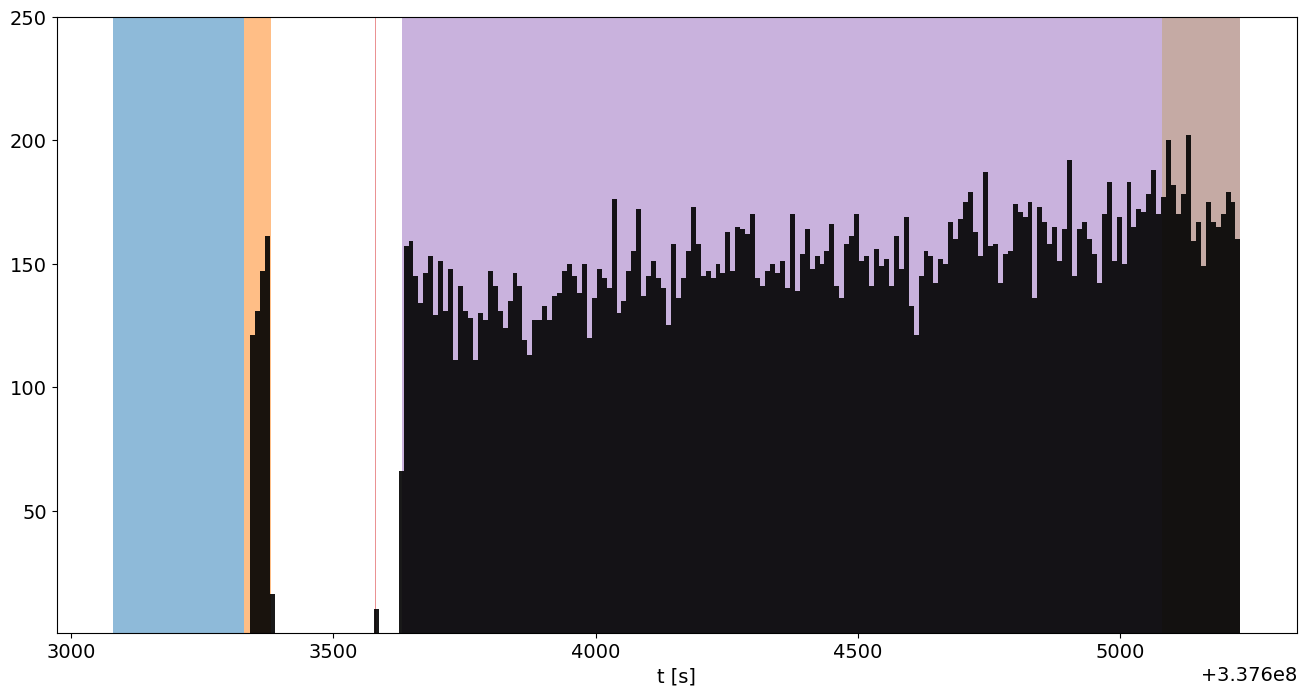

In [29]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
for i_int in range(len(good_time_ints)):
    ax.fill_between(x = good_time_ints[i_int], y1 = 2*[10**5],alpha=0.5)
ax.hist(df_events['t'],bins=200,color='black',alpha=0.9,log='False');
ax.set_xlabel('t [s]'); 
ax.set_yscale('linear')
ax.set_ylim(0.5,250);

(0.0, 100.0)

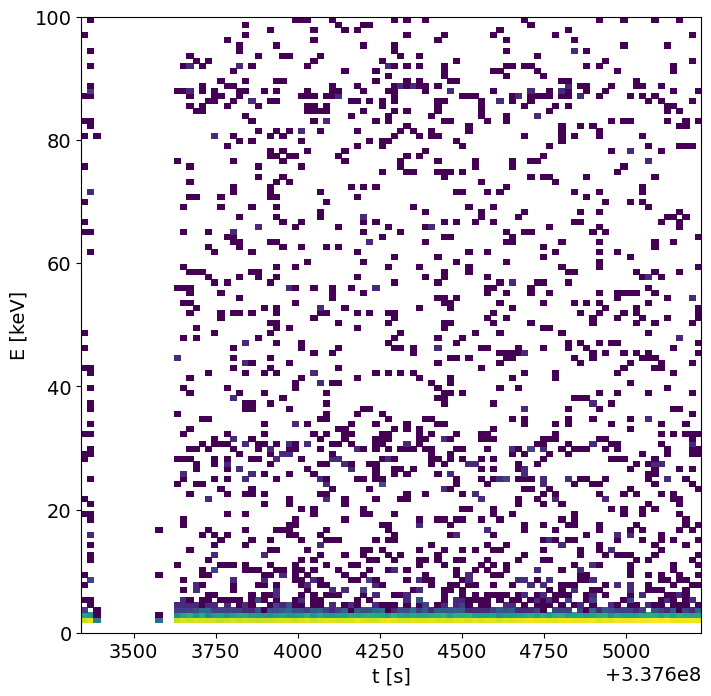

In [30]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.hist2d(df_events['t'],df_events['E'],bins=[100,200],norm=mp.colors.LogNorm());
ax.set_xlabel('t [s]'); ax.set_ylabel('E [keV]');
ax.set_ylim(0,100)